# Indepth EDA
Merging the three data sources to gain more insight and feature engineering

In [12]:
import os
import sys
# This should navigate to the repository root
sys.path.append('../../')
%reload_ext autoreload
%autoreload 2

import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from src.data import DATA_DIR

### Use the downcasted data

In [13]:
train_df = pd.read_pickle('../../data/interim/sales_train_validation.pkl')
sales_df = pd.read_pickle('../../data/interim/sell_prices.pkl')
calendar_df = pd.read_pickle('../../data/interim/calendar.pkl')

In [ ]:
FEATURES = ["dept_id", "weekday", "month", "year", "event_name", "event_type", "snap", "sell_prices"]

## Compare by weekdays
 - days range from d_1 to d_1913
 - list below shows the matching of the first 7 days to the weekdays. 

In [119]:
first_seven = calendar_df.head(7).groupby('weekday').first()
first_seven.sort_values(by=["wday"])

,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
weekday,,,,,,,,,,,,,
Saturday,2011-01-29,11101,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
Sunday,2011-01-30,11101,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
Monday,2011-01-31,11101,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
Tuesday,2011-02-01,11101,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
Wednesday,2011-02-02,11101,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
Thursday,2011-02-03,11101,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
Friday,2011-02-04,11101,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0


In [545]:
weekdays = np.unique(calendar_df['weekday'])
day_max = 1913

# find corresponding days to weekdays
weekdays_map = {w: ["d_{}".format(i) for i in np.arange(first_seven.loc[w].wday, day_max + 1, 7)] for w in weekdays}
for w in weekdays:
    train_df["total_{}".format(w.lower())] = train_df[weekdays_map[w]].sum(axis=1)
columns = ["total_{}".format(w.lower()) for w in weekdays]

# sum by dept_id and days of the week
summed = train_df.groupby('dept_id').sum()[columns].reset_index()
restuctured_sum = pd.melt(summed, id_vars=["dept_id"], var_name='days')
restuctured_sum.head()

,dept_id,days,value
0,FOODS_1,total_friday,768706
1,FOODS_2,total_friday,1012133
2,FOODS_3,total_friday,4570273
3,HOBBIES_1,total_friday,832723
4,HOBBIES_2,total_friday,74682


### Looking at it per days
- No shift in the ratio of type of product sold
- No suprise. It was obvious but more sales on the weekend

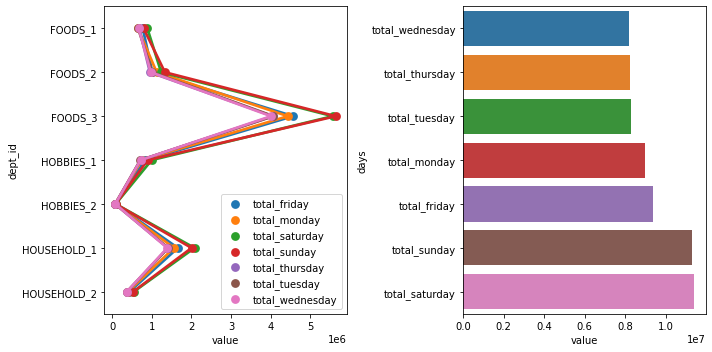

In [546]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.pointplot(x='value', y='dept_id', data=restuctured_sum, hue='days', ax=ax[0])
ax[0].legend()
sns.barplot(y='days', x='value', data=restuctured_sum.groupby(['days']).sum().reset_index().sort_values(by=["value"]), ax=ax[1])
fig.tight_layout()

## Compare by month

In [549]:
train_days = ['d_{}'.format(i) for i in np.arange(1, day_max+1, 1)]
train_calendar_df = calendar_df.loc[calendar_df["d"].isin(train_days)]

months = np.unique(train_calendar_df["month"])
assert len(months) == 12
months.sort()
months_map = [train_calendar_df.loc[train_calendar_df["month"] == m]['d'].values for m in months]

In [554]:
for m in months:
    train_df["total_{}".format(m)] = train_df[months_map[m-1]].sum(axis=1)
columns = ["total_{}".format(m) for m in months]
summed = train_df.groupby(['dept_id', 'state_id']).sum()[columns].reset_index()
restuctured_sum = pd.melt(summed, id_vars=["dept_id", 'state_id'], var_name='month')
restuctured_sum.head()

,dept_id,state_id,month,value
0,FOODS_1,CA,total_1,193887
1,FOODS_1,TX,total_1,113644
2,FOODS_1,WI,total_1,120177
3,FOODS_2,CA,total_1,262079
4,FOODS_2,TX,total_1,184329


## Plots
- similar results with the weekdays interms of the types of items sold
- certain months have more sales.. perhaps has to do with holidays

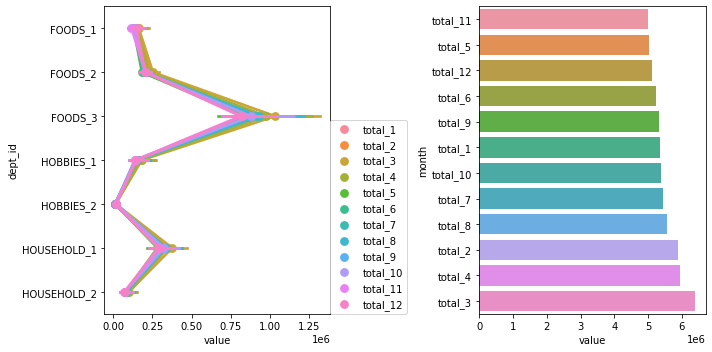

In [560]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.pointplot(x='value', y='dept_id', data=restuctured_sum, hue='month', ax=ax[0])
ax[0].legend(loc=(1,0))

sns.barplot(y='month', x='value', 
            data=restuctured_sum.groupby(['month']).sum().reset_index().sort_values(by=["value"]), ax=ax[1])
fig.tight_layout()

## Scaled avg by the state
 - perhaps weather plays a role?

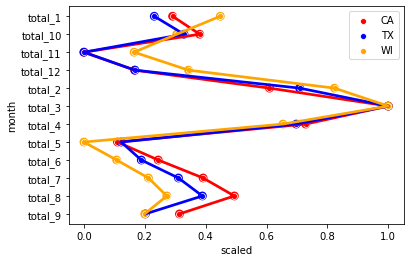

In [598]:
from sklearn.preprocessing import MinMaxScaler
avged = train_df.groupby(['dept_id', 'state_id']).mean()[columns].reset_index()
restuctured_avg = pd.melt(avged, id_vars=["dept_id", 'state_id'], var_name='month')
restuctured_avg.head()
data = restuctured_avg.groupby(['state_id', 'month']).mean().reset_index()
for state in ["CA", "WI", "TX"]:
    data.loc[data["state_id"]==state, "scaled"] = MinMaxScaler().fit_transform(data.loc[data["state_id"] == state][['value']])
    
colors =['red', 'blue', 'orange']
fig, ax = plt.subplots(1,1, figsize=(6,4))
for i, state in enumerate(["CA", "TX", "WI"]):
    sns.pointplot(y='month', x='scaled', 
                  data=data.loc[data["state_id"]==state].groupby(['month']).mean().reset_index(),
                  color=colors[i], label=state)
    sns.scatterplot(y='month', x='scaled', 
                  data=data.loc[data["state_id"]==state].groupby(['month']).mean().reset_index(),
                  color=colors[i], label=state)
ax.legend()

### Understanding events

In [279]:
event_calendar = train_calendar_df.loc[~pd.isnull(train_calendar_df["event_type_1"])]
events = event_calendar.drop_duplicates(subset=["event_name_1"])['event_name_1'].values
print("{}% of days make up event days".format(np.round(event_calendar.shape[0] / train_calendar_df.shape[0] *100, 2)))

8.05% of days make up event days


The months sale have nothing to do with the events

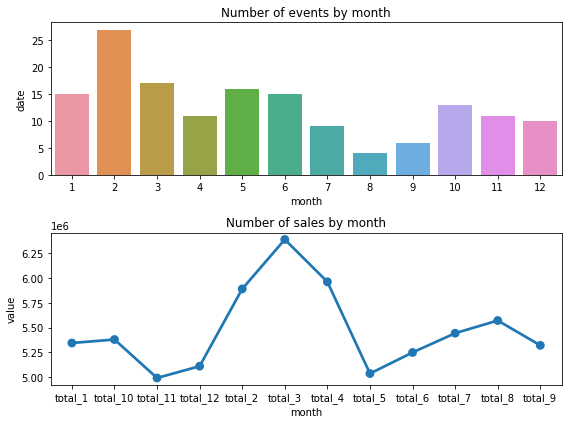

In [268]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
sns.barplot(x='month', y='date', 
            data=event_calendar.groupby('month').count()["date"].reset_index().sort_values(by=["date"]),
            ax=ax[0])
ax[0].set(title="Number of events by month")
sns.pointplot(y='value', x='month', 
              data=restuctured_sum.groupby(['month']).sum().reset_index().sort_values(by=["month"]),
              ax=ax[1])
ax[1].set(title="Number of sales by month")
fig.tight_layout()

### Do events fall under weekends usually?
- Emphasis on Monday and Sunday

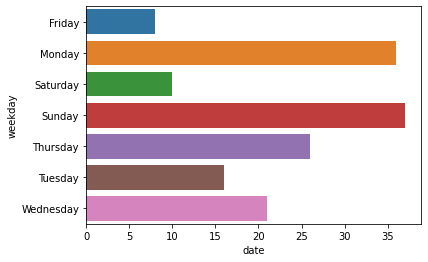

In [238]:
sns.barplot(y='weekday', x='date', 
            data=event_calendar.groupby('weekday').count()["date"].reset_index())

## Are there more sales during event days?
- Average sales are less during the event days
- Perhaps people are celebrating that day and we want to look at days leading up to the event

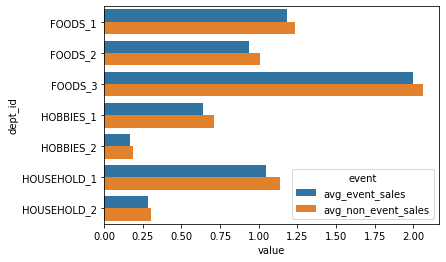

In [308]:
event_days = event_calendar["d"].values
all_days = ["d_{}".format(i) for i in np.arange(1, day_max+1, 1)]
non_event_days = [d for d in all_days if d not in event_days]

train_df["avg_event_sales"] = train_df[event_days].mean(axis=1)
train_df["avg_non_event_sales"] = train_df[non_event_days].mean(axis=1)

sns.barplot(y='dept_id', x='value', hue='event',
            data=pd.melt(train_df.groupby('dept_id')[["avg_event_sales", 'avg_non_event_sales']].mean().reset_index(),
                         id_vars='dept_id', var_name='event'))

## Do days leading up to events have more sale?
check day before and see if it's more than usual

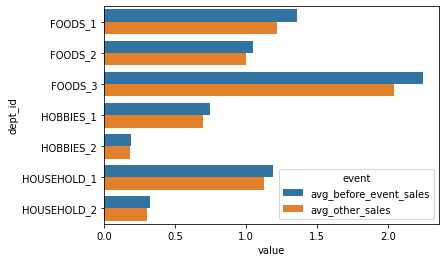

In [525]:
event_days = event_calendar["d"].values
day_before_event_days = ["d_{}".format( int(i.split("_")[1]) - 1 ) for i in event_days]
other_days = [d for d in all_days if d not in day_before_event_days]

train_df["avg_before_event_sales"] = train_df[day_before_event_days].mean(axis=1)
train_df["avg_other_sales"] = train_df[other_days].mean(axis=1)

sns.barplot(y='dept_id', x='value', hue='event',
            data=pd.melt(train_df.groupby('dept_id')[["avg_before_event_sales", 'avg_other_sales']].mean().reset_index(),
                         id_vars='dept_id', var_name='event'))

### Sales by event_type on the day before the event

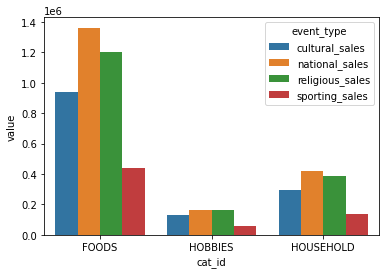

In [527]:
event_types = np.unique(event_calendar['event_type_1'])
days_by_event = {t: event_calendar.loc[event_calendar["event_type_1"]==t]["d"].values for t in event_types}
days_before_event = {event: ["d_{}".format(int(i.split("_")[1]) - 1) for i in days_by_event[event]] for event in days_by_event}
sales_by_event_type = None
for e in event_types:
    event_sum = train_df.groupby('cat_id')[days_before_event[e]].sum().sum(axis=1)\
        .reset_index().rename(columns={0: "{}_sales".format(e.lower())})
    if sales_by_event_type is None:
        sales_by_event_type = event_sum
    else:
        sales_by_event_type = sales_by_event_type.merge(event_sum, on=["cat_id"])
sales_by_event_type = pd.melt(sales_by_event_type, id_vars='cat_id', var_name='event_type')
sns.barplot(x='cat_id', y='value', hue='event_type', data=sales_by_event_type)

## sales by SNAP
 - more sales on snap days. Increases are different per state

In [632]:
snap_days_by_state = {
    "CA": train_calendar_df.loc[train_calendar_df["snap_CA"] > 0]["d"].values,
    "TX": train_calendar_df.loc[train_calendar_df["snap_TX"] > 0]["d"].values,
    "WI": train_calendar_df.loc[train_calendar_df["snap_WI"] > 0]["d"].values
}
non_snap_days_by_state = {
    "CA": train_calendar_df.loc[train_calendar_df["snap_CA"] == 0]["d"].values,
    "TX": train_calendar_df.loc[train_calendar_df["snap_TX"] == 0]["d"].values,
    "WI": train_calendar_df.loc[train_calendar_df["snap_WI"] == 0]["d"].values
}
snap_vs_not = []
for state in ['CA', 'WI', 'TX']:
    snap_vs_not.append([state, 
                        train_df.loc[train_df["state_id"] == state][snap_days_by_state[state]].sum().mean(),
                        train_df.loc[train_df["state_id"] == state][non_snap_days_by_state[state]].sum().mean()])
snap_df = pd.DataFrame(snap_vs_not, columns=["state", 'avg_snap', 'avg_non_snap'])
snap_df["increase"] = snap_df["avg_snap"] / snap_df["avg_non_snap"]
display(snap_df)

print("{}% are CA Snap days".format(np.round(len(snap_days_by_state['CA'])/len(day_column)*100, 2)))
print("{}% are WI Snap days".format(np.round(len(snap_days_by_state['WI'])/len(day_column)*100, 2)))
print("{}% are TX Snap days".format(np.round(len(snap_days_by_state['TX'])/len(day_column)*100, 2)))


,state,avg_snap,avg_non_snap,increase
0,CA,15771.885714,14605.813718,1.079836
1,WI,10763.577778,8838.505066,1.217805
2,TX,10612.734921,9519.082619,1.114891


32.93% are CA Snap days
32.93% are WI Snap days
32.93% are TX Snap days


### Price correlation to sales

In [634]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,total_9,total_10,total_11,total_12,event_sales,non_event_sales,avg_event_sales,avg_non_event_sales,avg_before_event_sales,avg_other_sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,56,50,57,68,42,558,0.272727,0.317226,0.331169,0.312109
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,31,47,38,107,40,453,0.259740,0.257533,0.344156,0.250142
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,29,16,23,47,18,270,0.116883,0.153496,0.175325,0.148380
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,279,277,269,266,262,3026,1.701299,1.720296,1.889610,1.703809
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,185,178,177,206,129,1720,0.837662,0.977828,1.129870,0.952246


In [633]:
sales_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812
